# I also included here sentiwordnet
- values between -1 and 1
-  It actually uses pattern library for that, which takes the individual word scores from sentiwordnet.
- trained on a dataset from movie reviews and the model used for it was a NaiveBayesAnalyzer
- https://github.com/sloria/TextBlob/blob/90cc87ab0f9e25f37379079840ec43aba59af440/textblob/en/sentiments.py

In [21]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
import pandas as pd
df = pd.read_csv('/content/gdrive/My Drive/Mestrado/sentiment_dataset.csv')

In [23]:
df.head()

,Unnamed: 0,text,sentiment
0,0,Hello and hope you are doing well.Understand y...,neutral
1,1,It would be hard to see any significant abnorm...,neutral
2,2,"Hi James, I, too, go to bed by 10:00, then wa...",neutral
3,3,"Hi, I am suffering from the same sleep problem...",negative
4,4,"me too, it feels like its morning after 1hour",neutral


In [24]:
! pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
#calculate the negative, positive, neutral and compound scores, plus verbal evaluation
#

def show_metrics(y_test, y_predicted):
  print(confusion_matrix(y_test, y_predicted))
  print(classification_report(y_test, y_predicted))


In [26]:
from textblob import TextBlob
# https://textblob.readthedocs.io/en/dev/api_reference.html#module-textblob.en.sentiments
import numpy as np
#call the classifier
def sentiment_texblob(row, threshold):
  
    classifier = TextBlob(row)
    polarity = classifier.sentiment.polarity
    subjectivity = classifier.sentiment.subjectivity

    if polarity >= threshold :
        overall_sentiment = "positive"

    elif polarity <= - threshold :
        overall_sentiment = "negative"

    else :
        overall_sentiment = "neutral"
    
    return polarity,subjectivity,overall_sentiment


def analise_text_blob(df, col_text, col_label):
  from sklearn import preprocessing

  le = preprocessing.LabelEncoder()
  le.fit(df[col_label])
  labels = le.transform(df[col_label])

  scores = []
  prediction_range = []
  for k in np.arange(0, 1, 0.05):
    predicted = []
    for X, y in zip(df[col_text], df[col_label]):
      predicted.append(sentiment_texblob(X, threshold=k)[-1])
    print("k = {}:".format(k))
    scores.append(f1_score(labels, le.transform(predicted), average="weighted"))
    prediction_range.append(accuracy_score(labels, le.transform(predicted)))


  ix = np.argmax(scores)
  print(np.arange(0, 1, 0.05)[ix])
  predicted = []
  for X, y in zip(df['text'], df['sentiment']):
    predicted.append(sentiment_texblob(X, np.arange(0, 1, 0.05)[ix])[-1])
  show_metrics(labels, le.transform(predicted))

  return scores, prediction_range

  

In [27]:
scores = analise_text_blob(df, 'text', 'sentiment')

k = 0.0:
k = 0.05:
k = 0.1:
k = 0.15000000000000002:
k = 0.2:
k = 0.25:
k = 0.30000000000000004:
k = 0.35000000000000003:
k = 0.4:
k = 0.45:
k = 0.5:
k = 0.55:
k = 0.6000000000000001:
k = 0.65:
k = 0.7000000000000001:
k = 0.75:
k = 0.8:
k = 0.8500000000000001:
k = 0.9:
k = 0.9500000000000001:
0.25
[[  6 126  10]
 [  9 237  44]
 [  0  28  27]]
              precision    recall  f1-score   support

           0       0.40      0.04      0.08       142
           1       0.61      0.82      0.70       290
           2       0.33      0.49      0.40        55

    accuracy                           0.55       487
   macro avg       0.45      0.45      0.39       487
weighted avg       0.52      0.55      0.48       487



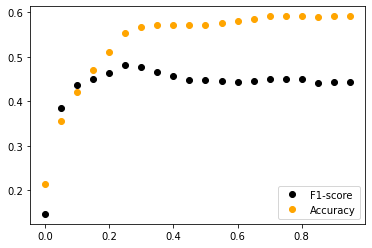

In [28]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0, 1, 0.05), scores[0], 'o', color='black', label="F1-score")
plt.plot(np.arange(0, 1, 0.05), scores[1], 'o', color='orange', label="Accuracy")
plt.legend(numpoints=1)


# Sentiwordnet

So when we are working with sentiwordnet we need to know the characterstic of the word for which we want to know the sentiment . So for finding that position of the word here we are gonna use nltk which tells us about the position of the word which then is used to get the sentiment using the sentiwordnet . We then average out the score for both the positive and the negative score from the whole sentence . The positions compatible with the sentiwordnet are:

In [29]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')
import ssl
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize 
import re
import spacy

# Function to preprocess Reviews data
def preprocess_Reviews_data(data,name):
    # Proprocessing the data
    data[name]=data[name].str.lower()
    # Code to remove the Hashtags from the text
    data[name]=data[name].apply(lambda x:re.sub(r'\B#\S+','',x))
    # Code to remove the links from the text
    data[name]=data[name].apply(lambda x:re.sub(r"http\S+", "", x))
    # Code to remove the Special characters from the text 
    data[name]=data[name].apply(lambda x:' '.join(re.findall(r'\w+', x)))
    # Code to substitute the multiple spaces with single spaces
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
    # Code to remove all the single characters in the text
    data[name]=data[name].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
    # Remove the twitter handlers
    data[name]=data[name].apply(lambda x:re.sub('@[^\s]+','',x))

# Function to tokenize and remove the stopwords    
def rem_stopwords_tokenize(data,name):
      
    def getting(sen):
        example_sent = sen
        
        filtered_sentence = [] 

        stop_words = set(stopwords.words('english')) 

        word_tokens = word_tokenize(example_sent) 
        
        filtered_sentence = [w for w in word_tokens if not w in stop_words] 
        
        return filtered_sentence
    # Using "getting(sen)" function to append edited sentence to data
    x=[]
    for i in data[name].values:
        x.append(getting(i))
    data[name]=x


lemmatizer = WordNetLemmatizer()
def Lemmatization(data,name):
    def getting2(sen):
        
        example = sen
        output_sentence =[]
        word_tokens2 = word_tokenize(example)
        lemmatized_output = [lemmatizer.lemmatize(w) for w in word_tokens2]
        
        # Remove characters which have length less than 2  
        without_single_chr = [word for word in lemmatized_output if len(word) > 2]
        # Remove numbers
        cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]
        
        return cleaned_data_title
    # Using "getting2(sen)" function to append edited sentence to data
    x=[]
    for i in data[name].values:
        x.append(getting2(i))
    data[name]=x


def make_sentences(data,name):
    data[name]=data[name].apply(lambda x:' '.join([i+' ' for i in x]))
    # Removing double spaces if created
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))


Edited_Review = df['text'].copy()
df['Review_without_stopwords'] = Edited_Review
# Using the preprocessing function to preprocess the hotel data
preprocess_Reviews_data(df,'Review_without_stopwords')
# Using tokenizer and removing the stopwords
rem_stopwords_tokenize(df,'Review_without_stopwords')
# Converting all the texts back to sentences
make_sentences(df,'Review_without_stopwords')

#Edits After Lemmatization
final_Edit = df['Review_without_stopwords'].copy()
df["After_lemmatization"] = final_Edit

# Using the Lemmatization function to lemmatize the hotel data
Lemmatization(df,'After_lemmatization')
# Converting all the texts back to sentences
make_sentences(df,'After_lemmatization')



pos=neg=obj=count=0

postagging = []

for review in df['After_lemmatization']:
    list = word_tokenize(review)
    postagging.append(nltk.pos_tag(list))

df['pos_tags'] = postagging

def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


# Returns list of pos-neg and objective score. But returns empty list if not present in senti wordnet.
def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    #Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    #Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
    #Synset instances are the groupings of synonymous words that express the same concept. 
    #Some of the words have only one Synset and some have several.
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    pos=neg=obj=count=0
    
    ###################################################################################
senti_score = []

for pos_val in df['pos_tags']:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  #positive score is stored at 2nd position
            neg = neg + score[2]  #negative score is stored at 3rd position
        except:
            continue
    senti_score.append(pos - neg)
    pos=neg=0    
    
df['senti_score'] = senti_score
#print(df['senti_score'])



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [30]:
df.head()

,Unnamed: 0,text,sentiment,Review_without_stopwords,After_lemmatization,pos_tags,senti_score
0,0,Hello and hope you are doing well.Understand y...,neutral,hello hope well understand predicament first s...,hello hope well understand predicament first s...,"[(hello, NN), (hope, VBP), (well, RB), (unders...",2.000
1,1,It would be hard to see any significant abnorm...,neutral,would hard see significant abnormalities scans...,would hard see significant abnormality scan te...,"[(would, MD), (hard, VB), (see, VB), (signific...",-2.000
2,2,"Hi James, I, too, go to bed by 10:00, then wa...",neutral,hi jamestoo go bed 10 00 wake 1 2 hours time t...,jamestoo bed wake hour time take hour beforeca...,"[(jamestoo, NN), (bed, VBD), (wake, VB), (hour...",1.625
3,3,"Hi, I am suffering from the same sleep problem...",negative,hiam suffering sleep problems symptoms changed...,hiam suffering sleep problem symptom changed g...,"[(hiam, NN), (suffering, VBG), (sleep, JJ), (p...",0.250
4,4,"me too, it feels like its morning after 1hour",neutral,feels like morning 1hour,feel like morning 1hour,"[(feel, NN), (like, IN), (morning, NN), (1hour...",0.125


In [31]:
range = np.arange(0, 1, 0.05)

In [33]:
## make prediction with sentiscore

def sentiscore(df, senti_score):

  for k in [0.05, 0.1, 0.15, 0.2]:
    print("k = {}".format(k))
    overall=[]
    for i in range(len(df)):
        if df[senti_score][i]>= k:
            overall.append('positive')
        elif df[senti_score][i]<= -k:
            overall.append('negative')
        else:
            overall.append('neutral')


    show_metrics(df['sentiment'], overall)

        
sentiscore(df, 'senti_score')

k = 0.05


TypeError: ignored